## Introduction
We choose to work on the Airline On-Time Arrivals. This is a typical binary classification problem. Let delay $>= 15$ min be positive 1 and delay $<15$ min be negative 0. 
<br>
There are several difficulties for this project. First, there are over one hundred fields one can download. We make some simple choices here. We use 'UniqueCarrier' to identify the airline, 'Origin' to represent the origin airport, 'Dest' to represent the destination airport. The choices are mainly based on the completeness of the data. We don't consider cancelled or diverted for simplicity. Secondly, there are tens of millions of data for over three decades. We choose to focus on the year 2016. Using part of the data for training and the other part for testing, we can build a model. This model is expected to give prediction to flight delay in 2017. We expect that the model is only useful for a short period since the air traffic, technology, and administration all evolve quickly. 

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import glob

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## Inpute Data
The first step is to import 2016 data from a local folder. We have already choosen the fields when we download data from the website.

In [2]:
path ='/Users/zhuyuecheng/Dropbox/MachineLearning/Jupynbs/AirlineArrivals' 
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    dfs = pd.read_csv(file_, parse_dates = ['FL_DATE'])
    list_.append(dfs)
df = pd.concat(list_)

In [3]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,FLIGHTS,DISTANCE_GROUP,Unnamed: 18
0,2016,1,1,6,3,2016-01-06,AA,DFW,DTW,-3.0,0.0,1100-1159,-6.0,0.0,1400-1459,158.0,1.0,4,NaN
1,2016,1,1,7,4,2016-01-07,AA,DFW,DTW,-4.0,0.0,1100-1159,-12.0,0.0,1400-1459,158.0,1.0,4,NaN
2,2016,1,1,8,5,2016-01-08,AA,DFW,DTW,-5.0,0.0,1100-1159,7.0,0.0,1400-1459,158.0,1.0,4,NaN
3,2016,1,1,9,6,2016-01-09,AA,DFW,DTW,2.0,0.0,1100-1159,-5.0,0.0,1400-1459,158.0,1.0,4,NaN
4,2016,1,1,10,7,2016-01-10,AA,DFW,DTW,100.0,1.0,1100-1159,113.0,1.0,1400-1459,158.0,1.0,4,NaN


In [4]:
df.columns

Index([u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
       u'FL_DATE', u'UNIQUE_CARRIER', u'ORIGIN', u'DEST', u'DEP_DELAY',
       u'DEP_DEL15', u'DEP_TIME_BLK', u'ARR_DELAY', u'ARR_DEL15',
       u'ARR_TIME_BLK', u'CRS_ELAPSED_TIME', u'FLIGHTS', u'DISTANCE_GROUP',
       u'Unnamed: 18'],
      dtype='object')

In [5]:
df.reset_index(inplace = True)
df = df.drop('index', axis = 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5617658 entries, 0 to 5617657
Data columns (total 19 columns):
YEAR                int64
QUARTER             int64
MONTH               int64
DAY_OF_MONTH        int64
DAY_OF_WEEK         int64
FL_DATE             datetime64[ns]
UNIQUE_CARRIER      object
ORIGIN              object
DEST                object
DEP_DELAY           float64
DEP_DEL15           float64
DEP_TIME_BLK        object
ARR_DELAY           float64
ARR_DEL15           float64
ARR_TIME_BLK        object
CRS_ELAPSED_TIME    float64
FLIGHTS             float64
DISTANCE_GROUP      int64
Unnamed: 18         float64
dtypes: datetime64[ns](1), float64(7), int64(6), object(5)
memory usage: 814.3+ MB


Drop 'Unnamed: 18'. Choose only 'Flight' == 1.0. We then change 'ARR_DEL15' and 'DEP_DEL15' to int. In order to avoid NA, we convert them to bool first as it fills in NA automatically. 

In [7]:
df = df.drop(['Unnamed: 18'], axis = 1)
df = df[df['FLIGHTS'] == 1.0]
df = df.drop(['FLIGHTS'], axis = 1)
df = df.astype({'ARR_DEL15':bool, 'DEP_DEL15': bool})
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP
0,2016,1,1,6,3,2016-01-06,AA,DFW,DTW,-3.0,False,1100-1159,-6.0,False,1400-1459,158.0,4
1,2016,1,1,7,4,2016-01-07,AA,DFW,DTW,-4.0,False,1100-1159,-12.0,False,1400-1459,158.0,4
2,2016,1,1,8,5,2016-01-08,AA,DFW,DTW,-5.0,False,1100-1159,7.0,False,1400-1459,158.0,4
3,2016,1,1,9,6,2016-01-09,AA,DFW,DTW,2.0,False,1100-1159,-5.0,False,1400-1459,158.0,4
4,2016,1,1,10,7,2016-01-10,AA,DFW,DTW,100.0,True,1100-1159,113.0,True,1400-1459,158.0,4


In [8]:
df = df.astype({'ARR_DEL15':int, 'DEP_DEL15': int})
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP
0,2016,1,1,6,3,2016-01-06,AA,DFW,DTW,-3.0,0,1100-1159,-6.0,0,1400-1459,158.0,4
1,2016,1,1,7,4,2016-01-07,AA,DFW,DTW,-4.0,0,1100-1159,-12.0,0,1400-1459,158.0,4
2,2016,1,1,8,5,2016-01-08,AA,DFW,DTW,-5.0,0,1100-1159,7.0,0,1400-1459,158.0,4
3,2016,1,1,9,6,2016-01-09,AA,DFW,DTW,2.0,0,1100-1159,-5.0,0,1400-1459,158.0,4
4,2016,1,1,10,7,2016-01-10,AA,DFW,DTW,100.0,1,1100-1159,113.0,1,1400-1459,158.0,4


In [9]:
df.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            5617648, 5617649, 5617650, 5617651, 5617652, 5617653, 5617654,
            5617655, 5617656, 5617657],
           dtype='int64', length=5617658)

We can now explore the data. 

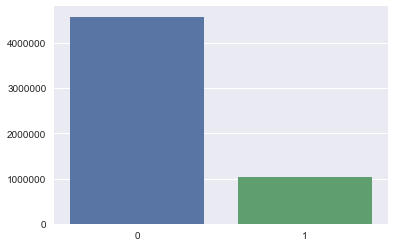

In [10]:
delay = df['ARR_DEL15'].value_counts()
sns.barplot(x = delay.index, y = delay.values)

In [11]:
df.describe()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE_GROUP
count,5617658.0,5.617658e+06,5.617658e+06,5.617658e+06,5.617658e+06,5.554202e+06,5.617658e+06,5.538145e+06,5.617658e+06,5.617652e+06,5.617658e+06
mean,2016.0,2.511934e+00,6.535810e+00,1.577741e+01,3.933906e+00,8.938011e+00,1.810361e-01,3.519290e+00,1.857984e-01,1.453971e+02,3.872194e+00
std,0.0,1.105887e+00,3.400847e+00,8.789841e+00,1.985502e+00,3.976306e+01,3.850481e-01,4.187332e+01,3.889439e-01,7.642798e+01,2.436703e+00
min,2016.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.040000e+02,0.000000e+00,-1.520000e+02,0.000000e+00,5.000000e+00,1.000000e+00
25%,2016.0,2.000000e+00,4.000000e+00,8.000000e+00,2.000000e+00,-5.000000e+00,0.000000e+00,-1.400000e+01,0.000000e+00,8.800000e+01,2.000000e+00
50%,2016.0,3.000000e+00,7.000000e+00,1.600000e+01,4.000000e+00,-2.000000e+00,0.000000e+00,-6.000000e+00,0.000000e+00,1.260000e+02,3.000000e+00
75%,2016.0,3.000000e+00,9.000000e+00,2.300000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.780000e+02,5.000000e+00
max,2016.0,4.000000e+00,1.200000e+01,3.100000e+01,7.000000e+00,2.149000e+03,1.000000e+00,2.142000e+03,1.000000e+00,7.050000e+02,1.100000e+01


In [12]:
print df[df['ARR_DEL15'] == 1]['ARR_DEL15'].count() / float(df['ARR_DEL15'].count())

0.185798423471


Therefore more than 80% flights are on time. 

## Explore Data Analysis
A first analysis of the data. We have 14 features 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_DELAY', 'DEP_DEL15', 'CRS_ELAPSED_TIME', 'DISTANCE_GROUP', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK', 'ARR_TIME_BLK' to use for the prediction. 

'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK' are date time.
<br>
'DEP_DELAY', 'CRS_ELAPSED_TIME' are numerical.
<br>
'DEP_DEL15', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST' are categorical.
<br>
'DISTANCE_GROUP','DEP_TIME_BLK', 'ARR_TIME_BLK' are ordinal.

'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK' are about the time.
<br>
'DEP_DELAY', 'DEP_DEL15', 'DEST', 'DEP_TIME_BLK', 'ORIGIN' are about the departure.
<br>
'CRS_ELAPSED_TIME', 'DISTANCE_GROUP' are about the flight duration.
<br>
'DEST', 'DEP_TIME_BLK', 'ARR_TIME_BLK' are about the arrival condition.
<br>
'UNIQUE_CARRIER' is the airline.
<br>
All five groups should be important.

From the graph, we see arrival delay (ARR_DEL) and departure delay (DEP_DEL) are highly correlated. 

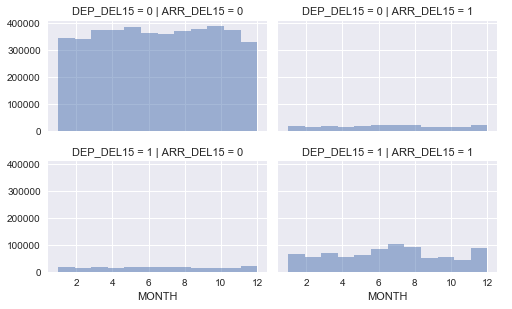

In [13]:
gMonth = sns.FacetGrid(df, row = 'DEP_DEL15', col = 'ARR_DEL15', size = 2.2, aspect = 1.6)
gMonth.map(plt.hist, 'MONTH', alpha = .5, bins = 12)
gMonth.add_legend();

Next consider the distribution of delays in different months. 

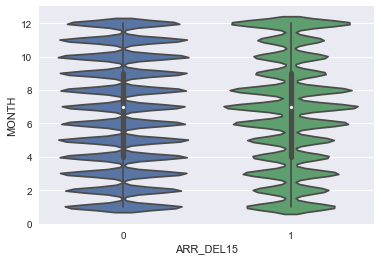

In [14]:
sns.violinplot(x = 'ARR_DEL15', y = 'MONTH', data = df)

In [15]:
byMonth = df[['MONTH','DEP_DELAY','ARR_DELAY','ORIGIN','DEST']].groupby('MONTH').mean()

In [16]:
byMonth

,DEP_DELAY,ARR_DELAY
MONTH,,
1,7.793537,1.533654
2,7.487446,0.665299
3,8.341402,3.145914
4,6.278522,0.696820
5,7.381552,2.249006
6,11.699589,7.154742
7,15.084373,10.384151
8,12.564364,8.013417
9,5.616416,0.499182


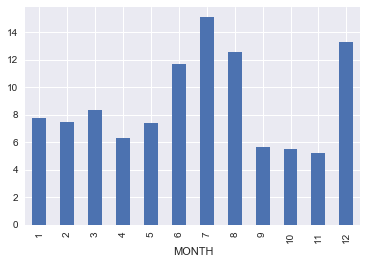

In [17]:
byMonth['DEP_DELAY'].plot(kind = 'bar')

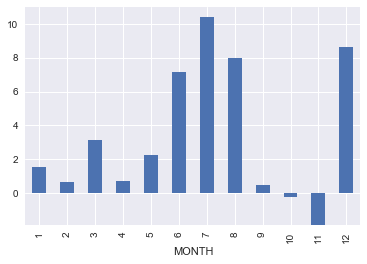

In [18]:
byMonth['ARR_DELAY'].plot(kind = 'bar')

As we can see Jun, Jul, Aug. This is not surprising since summer is the traveling season. There are also a lot of delays in December since it is the holiday season. The cold winter might also contribute to the delays. Sep, Oct, and Nov are the months with fewest delays(in terms of delay time). 

We now compare the delay time for different arrival hours. 

In [19]:
byHour = df[['ARR_TIME_BLK','DEP_DELAY','ARR_DELAY']].groupby('ARR_TIME_BLK').mean()
byHour

,DEP_DELAY,ARR_DELAY
ARR_TIME_BLK,,
0001-0559,14.122408,6.096906
0600-0659,4.967505,-1.497441
0700-0759,2.416934,-3.077590
0800-0859,2.136567,-2.502031
0900-0959,2.841372,-1.947445
1000-1059,3.367235,-1.868353
1100-1159,4.746269,-0.482163
1200-1259,5.134797,-0.224390
1300-1359,6.166574,0.725737


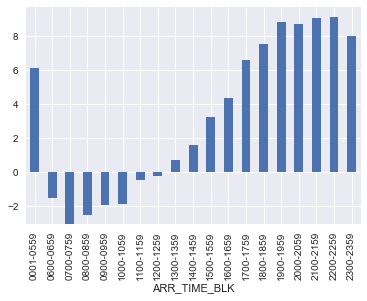

In [20]:
byHour['ARR_DELAY'].plot(kind = 'bar')

This shows that the delays generally get worse towards the end of the day. We think this is partly due to the possiblilties that delays propagate. The peak is around 18:00 - 23:00, the rush hours. 

In [21]:
byDayOfWeek = df[['DAY_OF_WEEK','DEP_DELAY','ARR_DELAY']].groupby('DAY_OF_WEEK').aggregate(np.mean)
byDayOfWeek

,DEP_DELAY,ARR_DELAY
DAY_OF_WEEK,,
1,9.307612,3.816911
2,7.911146,2.491794
3,7.542101,2.275777
4,9.956022,5.317991
5,10.497897,5.527220
6,7.981598,1.444029
7,9.152039,3.313080


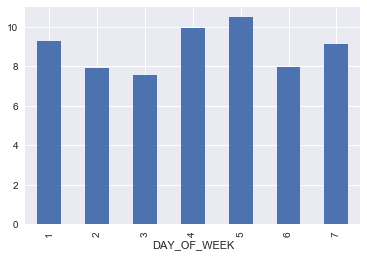

In [22]:
byDayOfWeek['DEP_DELAY'].plot(kind = 'bar')

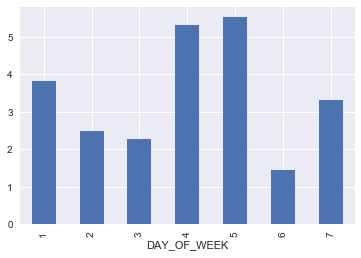

In [23]:
byDayOfWeek['ARR_DELAY'].plot(kind = 'bar')

Therefore Thursday and Friday have the most delays. Saturday usually has fewer delays. 

In [24]:
byDistance = df[['DISTANCE_GROUP','DEP_DELAY','ARR_DELAY']].groupby('DISTANCE_GROUP').aggregate(np.mean)
byDistance.head()

,DEP_DELAY,ARR_DELAY
DISTANCE_GROUP,,
1,6.994096,4.003504
2,8.177389,4.262310
3,8.583883,3.275098
4,9.300376,3.615045
5,10.720219,4.650178


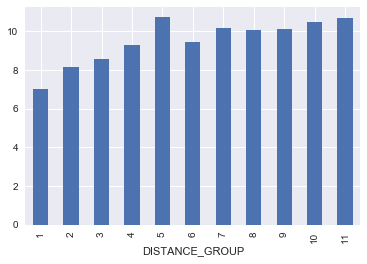

In [25]:
byDistance['DEP_DELAY'].plot(kind = 'bar')

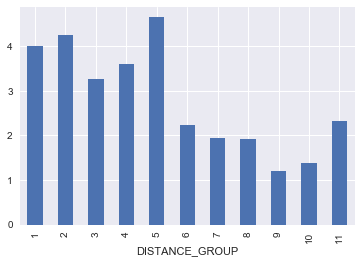

In [26]:
byDistance['ARR_DELAY'].plot(kind = 'bar')

While the distance does not influence the departure delay too much, longer distance leads to less delay. This is probablity due to the practice of buffering the schedules. As there are more flexibility in long distance flights. 

A very naive idea is the the longer distance can compensate the delay of the departure. So it makes sense to compute 'DEP_DELAY'/'CRS_ELAPSED_TIME'

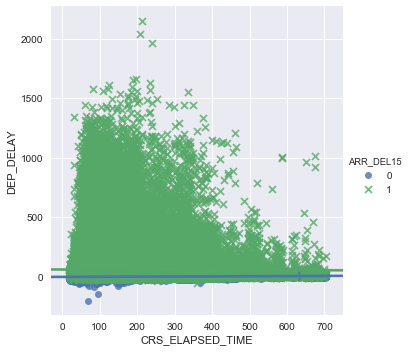

In [27]:
plt.figure(figsize = (10, 10))
g = sns.lmplot(x = 'CRS_ELAPSED_TIME', y = 'DEP_DELAY', hue = 'ARR_DEL15', markers=["o", "x"], data = df)
plt.show()

Compare the delay time for different airlines

In [28]:
byAirLine = df[['UNIQUE_CARRIER','DEP_DELAY','ARR_DELAY']].groupby('UNIQUE_CARRIER').aggregate(np.mean)
byAirLine

,DEP_DELAY,ARR_DELAY
UNIQUE_CARRIER,,
AA,8.924917,5.085089
AS,0.396170,-2.197627
B6,13.044043,8.052638
DL,7.938083,-0.556192
EV,9.605870,5.439869
F9,13.021153,7.790654
HA,-0.057246,-0.072610
NK,12.362833,9.328209
OO,7.512977,4.256732


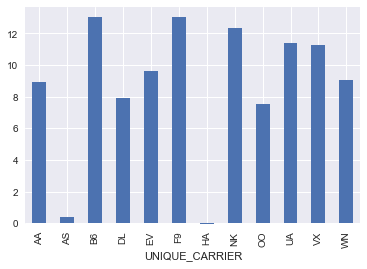

In [29]:
byAirLine['DEP_DELAY'].plot(kind = 'bar')

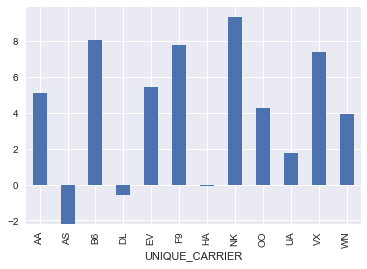

In [30]:
byAirLine['ARR_DELAY'].plot(kind = 'bar')

In [31]:
df[['UNIQUE_CARRIER','ARR_DEL15']].groupby('UNIQUE_CARRIER').mean()

,ARR_DEL15
UNIQUE_CARRIER,
AA,0.206164
AS,0.126709
B6,0.249932
DL,0.135235
EV,0.201904
F9,0.239831
HA,0.089205
NK,0.256782
OO,0.177219


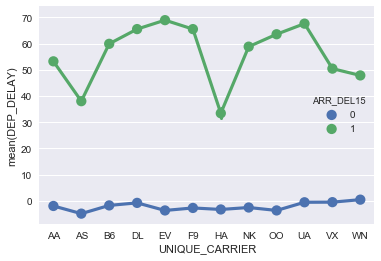

In [32]:
sns.pointplot(x ='UNIQUE_CARRIER', y = 'DEP_DELAY', hue = 'ARR_DEL15', data = df, palette='deep') 

AS and HA are smaller airlines that specializes in paticular routes. That is probably why they don't have a lot delays. While other airlines are much bigger and run flights all over the country. We can divide airlines into bands
(0.15, ) and (0, 0.15].

Compare the delay time for different airports.

In [33]:
byORIGIN = df[['ORIGIN','DEP_DELAY','ARR_DELAY']].groupby('ORIGIN').aggregate(np.mean)
byORIGIN

,DEP_DELAY,ARR_DELAY
ORIGIN,,
ABE,10.253431,4.038313
ABI,9.968354,10.254777
ABQ,8.062188,3.831237
ABR,5.908719,3.809004
ABY,7.714715,3.231231
ACK,14.898194,9.902961
ACT,7.242556,5.354651
ACV,12.919177,8.498898
ACY,11.717373,8.783611


We choose DFW(South), JFK(East), LAX(West) and ORD(Middle) to represent different geographic areas. Try to see if they perform differently for different seasons. 

In [34]:
DFWorigin_df = df[df['ORIGIN'] == 'DFW'].groupby('MONTH').aggregate(np.mean)
DFWorigin_df.head()

,YEAR,QUARTER,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,DEP_DEL15,ARR_DELAY,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE_GROUP
MONTH,,,,,,,,,,
1,2016.0,1.0,15.929369,4.136372,5.992168,0.161425,0.903433,0.163719,143.759070,3.837308
2,2016.0,1.0,14.936811,3.825729,5.241838,0.142579,0.843254,0.151782,144.044135,3.843227
3,2016.0,1.0,16.013612,3.881014,12.482714,0.233161,10.186241,0.254694,144.404424,3.854729
4,2016.0,2.0,15.484300,4.047625,8.512166,0.179166,4.730903,0.190995,146.081563,3.868892
5,2016.0,2.0,15.920213,3.865087,11.054221,0.204364,7.177612,0.218810,148.399662,3.902563


In [35]:
JFKorigin_df = df[df['ORIGIN'] == 'JFK'].groupby('MONTH').aggregate(np.mean)
ORDorigin_df = df[df['ORIGIN'] == 'ORD'].groupby('MONTH').aggregate(np.mean)
LAXorigin_df = df[df['ORIGIN'] == 'LAX'].groupby('MONTH').aggregate(np.mean)
DFWdest_df = df[df['DEST'] == 'DFW'].groupby('MONTH').aggregate(np.mean)
JFKdest_df = df[df['DEST'] == 'JFK'].groupby('MONTH').aggregate(np.mean)
ORDdest_df = df[df['DEST'] == 'ORD'].groupby('MONTH').aggregate(np.mean)
LAXdest_df = df[df['DEST'] == 'LAX'].groupby('MONTH').aggregate(np.mean)


We compare the delays for different cities.

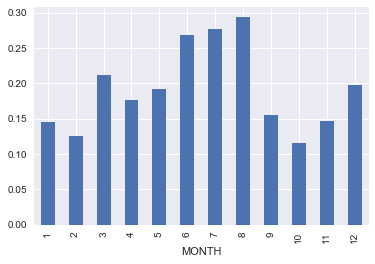

In [36]:
DFWdest_df['ARR_DEL15'].plot(kind = 'bar')

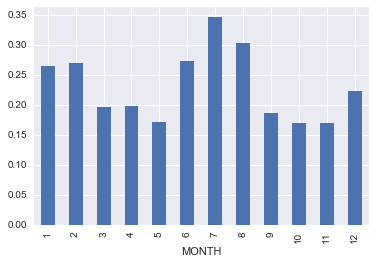

In [37]:
JFKdest_df['ARR_DEL15'].plot(kind = 'bar')

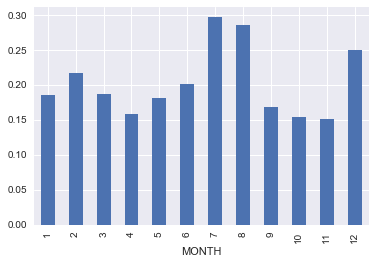

In [38]:
ORDdest_df['ARR_DEL15'].plot(kind = 'bar')

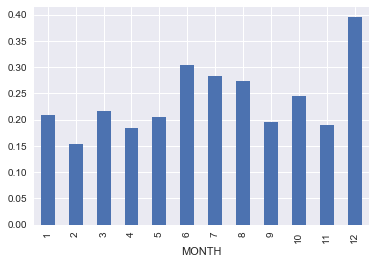

In [39]:
LAXdest_df['ARR_DEL15'].plot(kind = 'bar')

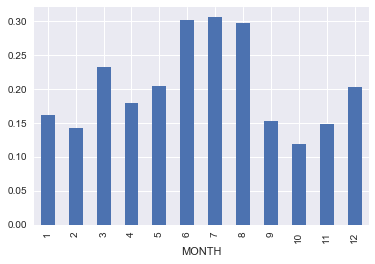

In [40]:
DFWorigin_df['DEP_DEL15'].plot(kind = 'bar')

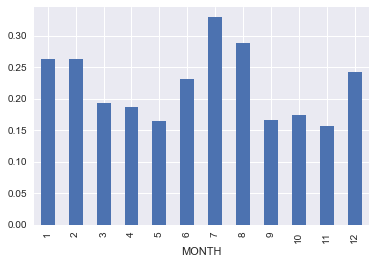

In [41]:
JFKorigin_df['DEP_DEL15'].plot(kind = 'bar')

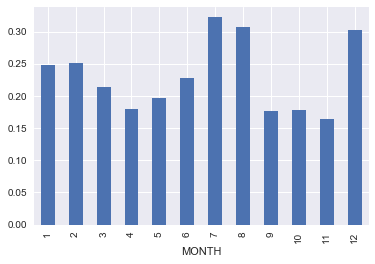

In [42]:
ORDorigin_df['DEP_DEL15'].plot(kind = 'bar')

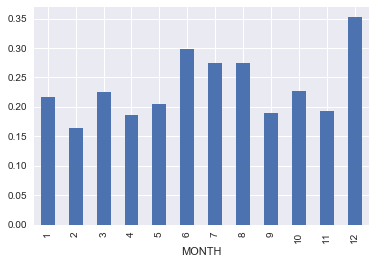

In [43]:
LAXorigin_df['DEP_DEL15'].plot(kind = 'bar')

We don't see much differences across different airports as both origin and destination. Except LA has more delays in December. Maybe in December more people are traveling to California. 

Ideally we should group ORIGIN and DEST into different categories by its geographic locations. The information geographic location combined with seasons may give some information. But let's assume that there is no correlation. At least not obvious from the above graphes. 

Due to the limit of time and resource, we will simply classify airports according to their arrival delay. 

## Feature Engineering

1) Construct a new feature 'DEP_DELAY/CRS_ELAPSED_TIME'
<br>
2) Drop 'YEAR', 'QUATER', 'DAY_OF_MONTH', 'ORIGIN', 'DISTANCE_GROUP', 'DEP_TIME_BLK'
<br>
3) BAND 'UNIQUE_CARRIER', 'DEST' into groups
<br>
4) BAND 'ARR_TIME_BAND' further.

In [44]:
df['DEP_DELAY/CRS_ELAPSED_TIME'] = df['DEP_DELAY']/(df['CRS_ELAPSED_TIME'])

In [45]:
df = df[df['DEP_DELAY/CRS_ELAPSED_TIME'].notnull()]
llimit = np.percentile(df['DEP_DELAY/CRS_ELAPSED_TIME'].values, 1)
ulimit = np.percentile(df['DEP_DELAY/CRS_ELAPSED_TIME'].values, 99) 
df.replace(np.inf, ulimit)
df.replace(np.inf, llimit)
df.loc[df['DEP_DELAY/CRS_ELAPSED_TIME'] < llimit, 'DEP_DELAY/CRS_ELAPSED_TIME'] = llimit
df.loc[df['DEP_DELAY/CRS_ELAPSED_TIME'] > ulimit, 'DEP_DELAY/CRS_ELAPSED_TIME'] = ulimit

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,DEP_DELAY/CRS_ELAPSED_TIME
0,2016,1,1,6,3,2016-01-06,AA,DFW,DTW,-3.0,0,1100-1159,-6.0,0,1400-1459,158.0,4,-0.018987
1,2016,1,1,7,4,2016-01-07,AA,DFW,DTW,-4.0,0,1100-1159,-12.0,0,1400-1459,158.0,4,-0.025316
2,2016,1,1,8,5,2016-01-08,AA,DFW,DTW,-5.0,0,1100-1159,7.0,0,1400-1459,158.0,4,-0.031646
3,2016,1,1,9,6,2016-01-09,AA,DFW,DTW,2.0,0,1100-1159,-5.0,0,1400-1459,158.0,4,0.012658
4,2016,1,1,10,7,2016-01-10,AA,DFW,DTW,100.0,1,1100-1159,113.0,1,1400-1459,158.0,4,0.632911


In [47]:
byDEST = df[['DEST', 'ARR_DEL15']].groupby('DEST', as_index = False).mean()
byDEST.head()


,DEST,ARR_DEL15
0,ABE,0.182209
1,ABI,0.208861
2,ABQ,0.181123
3,ABR,0.095109
4,ABY,0.181363


In [48]:
byDEST['DEST_BAND'] = pd.cut(byDEST['ARR_DEL15'], 5)
byDEST[['DEST_BAND', 'ARR_DEL15']].groupby(['DEST_BAND'],\
                                          as_index=False).mean().sort_values(by='DEST_BAND', ascending=True)

,DEST_BAND,ARR_DEL15
0,"(-0.000349, 0.0699]",0.036804
1,"(0.0699, 0.14]",0.113825
2,"(0.14, 0.21]",0.172557
3,"(0.21, 0.28]",0.235300
4,"(0.28, 0.349]",0.318777


In [49]:
byDEST.head()

,DEST,ARR_DEL15,DEST_BAND
0,ABE,0.182209,"(0.14, 0.21]"
1,ABI,0.208861,"(0.14, 0.21]"
2,ABQ,0.181123,"(0.14, 0.21]"
3,ABR,0.095109,"(0.0699, 0.14]"
4,ABY,0.181363,"(0.14, 0.21]"


In [50]:
byDEST['BAND'] = 0
byDEST.loc[ byDEST['ARR_DEL15'] <= 0.0747, 'BAND'] = 0
byDEST.loc[(byDEST['ARR_DEL15'] > 0.0747) & (byDEST['ARR_DEL15'] <= 0.149), 'BAND'] = 1
byDEST.loc[(byDEST['ARR_DEL15'] > 0.149) & (byDEST['ARR_DEL15'] <= 0.224), 'BAND'] = 2
byDEST.loc[(byDEST['ARR_DEL15'] > 0.224) & (byDEST['ARR_DEL15'] <= 0.299), 'BAND'] = 3
byDEST.loc[ byDEST['ARR_DEL15'] > 0.299, 'BAND'] = 4
byDEST.head()

,DEST,ARR_DEL15,DEST_BAND,BAND
0,ABE,0.182209,"(0.14, 0.21]",2
1,ABI,0.208861,"(0.14, 0.21]",2
2,ABQ,0.181123,"(0.14, 0.21]",2
3,ABR,0.095109,"(0.0699, 0.14]",1
4,ABY,0.181363,"(0.14, 0.21]",2


In [51]:
dest_map = pd.Series(byDEST.BAND.values,index=byDEST.DEST).to_dict()
df['DEST_AIRPORT'] = df['DEST'].map(dest_map)
df.head()

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,DEP_DELAY/CRS_ELAPSED_TIME,DEST_AIRPORT
0,2016,1,1,6,3,2016-01-06,AA,DFW,DTW,-3.0,0,1100-1159,-6.0,0,1400-1459,158.0,4,-0.018987,1
1,2016,1,1,7,4,2016-01-07,AA,DFW,DTW,-4.0,0,1100-1159,-12.0,0,1400-1459,158.0,4,-0.025316,1
2,2016,1,1,8,5,2016-01-08,AA,DFW,DTW,-5.0,0,1100-1159,7.0,0,1400-1459,158.0,4,-0.031646,1
3,2016,1,1,9,6,2016-01-09,AA,DFW,DTW,2.0,0,1100-1159,-5.0,0,1400-1459,158.0,4,0.012658,1
4,2016,1,1,10,7,2016-01-10,AA,DFW,DTW,100.0,1,1100-1159,113.0,1,1400-1459,158.0,4,0.632911,1


In [52]:
df['AIRLINE'] = 1
df.loc[(df['UNIQUE_CARRIER'] == 'AS') | (df['UNIQUE_CARRIER'] == 'DL') | (df['UNIQUE_CARRIER'] == 'HA'), 'AIRLINE'] = 0
df.head()

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,DEP_DELAY/CRS_ELAPSED_TIME,DEST_AIRPORT,AIRLINE
0,2016,1,1,6,3,2016-01-06,AA,DFW,DTW,-3.0,0,1100-1159,-6.0,0,1400-1459,158.0,4,-0.018987,1,1
1,2016,1,1,7,4,2016-01-07,AA,DFW,DTW,-4.0,0,1100-1159,-12.0,0,1400-1459,158.0,4,-0.025316,1,1
2,2016,1,1,8,5,2016-01-08,AA,DFW,DTW,-5.0,0,1100-1159,7.0,0,1400-1459,158.0,4,-0.031646,1,1
3,2016,1,1,9,6,2016-01-09,AA,DFW,DTW,2.0,0,1100-1159,-5.0,0,1400-1459,158.0,4,0.012658,1,1
4,2016,1,1,10,7,2016-01-10,AA,DFW,DTW,100.0,1,1100-1159,113.0,1,1400-1459,158.0,4,0.632911,1,1


In [53]:
#As a very simple model, use 'MONTH', 'DAY_OF_WEEK', 'DEP_DELAY', 'DISTANCE_GROUP', 'DEST', 'ARR_TIME_BLK','UNIQUE_CARRIER' should already gives a simple model. 

sample_df = df[['ARR_DEL15','DEP_DELAY/CRS_ELAPSED_TIME']]

In [54]:
sample_df['DEP_DELAY/CRS_ELAPSED_TIME'].isnull().values.any()

False

In [55]:
train_df, test_df = train_test_split(sample_df, test_size = 0.2)

In [56]:
X_train = train_df.drop(['ARR_DEL15'], axis=1)
X_test = test_df.drop(['ARR_DEL15'], axis = 1)
Y_train = train_df['ARR_DEL15']
Y_test = test_df['ARR_DEL15']

In [57]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

92.54

In [58]:
target_names = ['ONTIME', 'DELAYED']
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.98      0.96    914945
    DELAYED       0.88      0.67      0.76    195895

avg / total       0.92      0.93      0.92   1110840



What we find is we can predict the delay well from just one feature 'DEP_DELAY/CRS_ELAPSED_TIME'
So we can drop most of the features from now on. 

In [59]:
df.loc[(df['ARR_TIME_BLK'] == '0001-0559') |(df['ARR_TIME_BLK'] == '0600-0659')|(df['ARR_TIME_BLK'] == '0700-0759')|(df['ARR_TIME_BLK'] == '0800-0859') , 'ARR_TIME_BLK'] = 1
df.loc[(df['ARR_TIME_BLK'] == '0900-0959') |(df['ARR_TIME_BLK'] == '1000-1059')|(df['ARR_TIME_BLK'] == '1100-1159') , 'ARR_TIME_BLK'] = 2
df.loc[(df['ARR_TIME_BLK'] == '1200-1259') |(df['ARR_TIME_BLK'] == '1300-1359')|(df['ARR_TIME_BLK'] == '1400-1459') , 'ARR_TIME_BLK'] = 3
df.loc[(df['ARR_TIME_BLK'] == '1500-1559') |(df['ARR_TIME_BLK'] == '1600-1659')|(df['ARR_TIME_BLK'] == '1700-1759') , 'ARR_TIME_BLK'] = 4
df.loc[(df['ARR_TIME_BLK'] == '1800-1859') |(df['ARR_TIME_BLK'] == '1900-1959')|(df['ARR_TIME_BLK'] == '2000-2059') , 'ARR_TIME_BLK'] = 5
df.loc[(df['ARR_TIME_BLK'] == '2100-2159') |(df['ARR_TIME_BLK'] == '2200-2259')|(df['ARR_TIME_BLK'] == '2300-2359') , 'ARR_TIME_BLK'] = 6
df['ARR_TIME_BLK'] = df['ARR_TIME_BLK'].astype(int)
df.head()

/Users/zhuyuecheng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_DELAY,DEP_DEL15,DEP_TIME_BLK,ARR_DELAY,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE_GROUP,DEP_DELAY/CRS_ELAPSED_TIME,DEST_AIRPORT,AIRLINE
0,2016,1,1,6,3,2016-01-06,AA,DFW,DTW,-3.0,0,1100-1159,-6.0,0,3,158.0,4,-0.018987,1,1
1,2016,1,1,7,4,2016-01-07,AA,DFW,DTW,-4.0,0,1100-1159,-12.0,0,3,158.0,4,-0.025316,1,1
2,2016,1,1,8,5,2016-01-08,AA,DFW,DTW,-5.0,0,1100-1159,7.0,0,3,158.0,4,-0.031646,1,1
3,2016,1,1,9,6,2016-01-09,AA,DFW,DTW,2.0,0,1100-1159,-5.0,0,3,158.0,4,0.012658,1,1
4,2016,1,1,10,7,2016-01-10,AA,DFW,DTW,100.0,1,1100-1159,113.0,1,3,158.0,4,0.632911,1,1


In [60]:
df = df.drop(['YEAR','QUARTER','DAY_OF_MONTH', 'FL_DATE', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_DELAY','DEP_DEL15', 'DEP_TIME_BLK', 'ARR_DELAY','CRS_ELAPSED_TIME', 'DISTANCE_GROUP'], axis = 1)
df.columns.values

array(['MONTH', 'DAY_OF_WEEK', 'ARR_DEL15', 'ARR_TIME_BLK',
       'DEP_DELAY/CRS_ELAPSED_TIME', 'DEST_AIRPORT', 'AIRLINE'], dtype=object)

## Train Models

In [61]:
train_df, test_df = train_test_split(df, test_size = 0.1)
train_df.head()

,MONTH,DAY_OF_WEEK,ARR_DEL15,ARR_TIME_BLK,DEP_DELAY/CRS_ELAPSED_TIME,DEST_AIRPORT,AIRLINE
4113890,6,1,1,6,1.556391,2,1
1730290,12,6,0,5,0.006309,2,1
973787,11,7,0,3,-0.054054,2,1
3228407,5,7,0,5,0.042254,2,0
4152772,6,1,0,5,-0.025641,2,1


In [62]:
X_train = train_df.drop(['ARR_DEL15'], axis = 1)
X_test  = test_df.drop(['ARR_DEL15'], axis = 1)
Y_train = train_df['ARR_DEL15']
Y_test = test_df['ARR_DEL15']
Y_test.head()

1941436    0
343931     0
4521593    0
1684131    0
5616862    1
Name: ARR_DEL15, dtype: int64

First, we use a single model. Pick models from Linear Regression, Linear SVC, Gaussian Naive Bayes, Perceptron, Decision Tree and Random Forest.

In [81]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

92.61

In [82]:
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
3,DEP_DELAY/CRS_ELAPSED_TIME,16.203473
4,DEST_AIRPORT,0.413280
5,AIRLINE,0.214282
2,ARR_TIME_BLK,0.048959
0,MONTH,0.007552
1,DAY_OF_WEEK,-0.006738


In [83]:
target_names = ['ONTIME', 'DELAYED']
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.98      0.96    457776
    DELAYED       0.88      0.67      0.76     97644

avg / total       0.92      0.93      0.92    555420



In [84]:
print(accuracy_score(Y_test, Y_pred))

0.926732922833


In [64]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

92.56

In [65]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.98      0.96    457776
    DELAYED       0.89      0.66      0.76     97644

avg / total       0.92      0.93      0.92    555420



In [66]:
print(accuracy_score(Y_test, Y_pred))

0.926245003781


In [67]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

92.57

In [68]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.94      0.98      0.96    457776
    DELAYED       0.86      0.69      0.77     97644

avg / total       0.92      0.93      0.92    555420



In [69]:
print(accuracy_score(Y_test, Y_pred))

0.926153181376


In [70]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

91.46

In [71]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.94      0.95      0.95    457776
    DELAYED       0.77      0.74      0.75     97644

avg / total       0.91      0.92      0.91    555420



In [72]:
print(accuracy_score(Y_test, Y_pred))

0.915269525764


In [73]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

97.06

In [74]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.95      0.94    457776
    DELAYED       0.75      0.67      0.71     97644

avg / total       0.90      0.90      0.90    555420



In [75]:
print(accuracy_score(Y_test, Y_pred))

0.903078751215


In [76]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

97.06

In [77]:
print(classification_report(Y_test, Y_pred, target_names=target_names))

             precision    recall  f1-score   support

     ONTIME       0.93      0.96      0.94    457776
    DELAYED       0.76      0.68      0.72     97644

avg / total       0.90      0.91      0.91    555420



In [78]:
print(accuracy_score(Y_test, Y_pred))

0.907136941414


## Evaluation
Evaluation of the models: Logistic regression, Linear SVC and Gaussian Naive Bayes are the best. The results are also close to the simple model using only one feature 'DEP_DELAY/CRS_ELAPSED_TIME'. Therefore there is no essential improvement from including other features. The f1 score is 0.92, which is quite good. 
<br>
The Perceptron, Decision Tree and Random Forest behave worse. The f1 scores are all around 0.91. In particular, Decesion Tree and Random Forest overfits the training data. 

## Conclusion
The conclusion is the engineered feature 'DEP_DELAY/CRS_ELAPSED_TIME' alone can predict the arrival delay very well. The explaination is that the makeup minutes / flight minute is almost fixed. The longer the flight is, the more delayed time can be saved. It basically determines whether a flight will arrive at the destination on time. All other features may be used to make further corrections if we use boosting methods.
<br>
This prediction is based on the condition that we have the information about the departure. That is the prediction can only be made after the flight takes off. However, if we want to predict delays before the departure, we need to predict the departure delays as well. For that case, it is better to include weather data. Moreover, if the target flight is scheduled late in the day, we can also include data about the early delays of filghts. 